In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import MaxPool2D, Conv2D, Flatten, Dropout, Dense
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import LearningRateScheduler, EarlyStopping
import keras.backend as K
import os
import zipfile

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./model/cats_and_dogs_filtered.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
with zipfile.ZipFile('./model/cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('./model/cats_and_dogs_filtered')

In [ ]:
train_gen = ImageDataGenerator(rescale = 1 / 255, width_shift_range = 0.1, height_shift_range = 0.1, rotation_range = 0.15,
                                     zoom_range = 0.15)

val_gen = ImageDataGenerator(rescale = 1 / 255)

In [ ]:
train_dir = './model/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
val_dir = './model/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [ ]:
train_generator = train_gen.flow_from_directory(train_dir, target_size = (150, 150), class_mode = 'binary', batch_size = 20)
val_generator = val_gen.flow_from_directory(val_dir, target_size = (150, 150), class_mode = 'binary', batch_size = 20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Text(0.5, 1.0, '0.0')

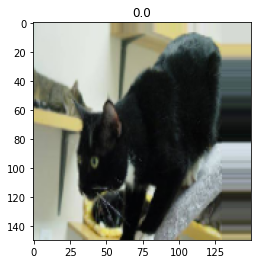

In [ ]:
plt.imshow(train_generator[0][0][0])
plt.title(train_generator[0][1][0])

In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = InceptionV3(include_top = False, input_shape = (150, 150, 3))

for layer in model.layers:
    layer.trainable = False

last_layer = model.get_layer('mixed7')
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = 'sigmoid')(x)

transfered_model = Model(model.input, x)
transfered_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [precision_m, recall_m, f1_m])

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4)

In [ ]:
transfered_model.fit(train_generator, validation_data = val_generator, epochs = 10, callbacks = [annealer, early_stop])

Epoch 1/10
100/100 [==============================] - 29s 244ms/step - loss: 0.4451 - precision_m: 0.9155 - recall_m: 0.9113 - f1_m: 0.9056 - val_loss: 0.1773 - val_precision_m: 0.9657 - val_recall_m: 0.9562 - val_f1_m: 0.9584 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 23s 227ms/step - loss: 0.1714 - precision_m: 0.9555 - recall_m: 0.9550 - f1_m: 0.9519 - val_loss: 0.2433 - val_precision_m: 0.9316 - val_recall_m: 0.9729 - val_f1_m: 0.9493 - lr: 9.5000e-04
Epoch 3/10
100/100 [==============================] - 22s 217ms/step - loss: 0.1388 - precision_m: 0.9603 - recall_m: 0.9598 - f1_m: 0.9564 - val_loss: 0.1612 - val_precision_m: 0.9789 - val_recall_m: 0.9399 - val_f1_m: 0.9573 - lr: 9.0250e-04
Epoch 4/10
100/100 [==============================] - 22s 221ms/step - loss: 0.0745 - precision_m: 0.9834 - recall_m: 0.9755 - f1_m: 0.9778 - val_loss: 0.1660 - val_precision_m: 0.9810 - val_recall_m: 0.9349 - val_f1_m: 0.9545 - lr: 8.5737e-04
Epoch 5/10
100/100 [========

In [ ]:
transfered_model.save('./model/cat_vs_dog_classifier.h5')